# Protected Probabilistic Classification

This notebook gives an implementation example of Protected classification for binary classification problems. 

Protected classification is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Alex Gammerman. "Protected probabilistic classification." In Conformal and Probabilistic Prediction and Applications, pp. 297-299. PMLR, 2021. (arxiv version https://arxiv.org/pdf/2107.01726.pdf)

In this example we focus on the **streaming** problem application compatible with the online machine learning package **River** available at https://riverml.xyz

## Import libraries

In [1]:
# !pip install river

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

import calibration as cal

from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.metrics import log_loss, brier_score_loss, roc_curve, roc_auc_score

import pandas as pd

from river import drift, compose, feature_extraction
from river import linear_model, forest, ensemble, tree, naive_bayes, neighbors
from river import metrics, preprocessing
from river import datasets

from protected_classification import ProtectedClassification, y_pred_encode, p_pred_encode

## Import dataset (binary classifcation in a streaming setting)

In [3]:
dataset =  datasets.Phishing()
clf = forest.ARFClassifier()

random.seed(2025)

In [4]:
print(dataset.desc)
print('')
print('Number of features: ' + str(dataset.n_features))
print('Number of samples: ' + str(dataset.n_samples))

Phishing websites.

This dataset contains features from web pages that are classified as phishing or not.

Number of features: 9
Number of samples: 1250


##  Classify in an online setting

Here we perform classification where the underlying algorithm Adaptive Random Forest (ARF) from the **River** package learns one example at a time. We perform the equivalent learning/calibration either every new example using the protected classification algorithm via a function **learn_one** and **predict_proba_one**

In [5]:
pc = ProtectedClassification()

scratch = []
metric_acc = {}
metric_acc['base'] = metrics.Accuracy()
metric_acc['prot'] = metrics.Accuracy()

metric_roc = {}
metric_roc['base'] = metrics.ROCAUC()
metric_roc['prot'] = metrics.ROCAUC()

logloss = {}
logloss['base'] = []
logloss['prot'] = []

brierloss = {}
brierloss['base'] = []
brierloss['prot'] = []

acc = {}
acc['base'] = []
acc['prot'] = []

y_preds = []
y_primes = []
y_test = []
p_preds = []
p_primes = []

counter = 0
classes = []

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    clf
)


for x, y in dataset:
    counter += 1
    print('\r', "{:.0%}".format(counter/dataset.n_samples), end='')
    classes.append(y)
    classes_unique = np.unique(np.array(classes))

    # classifier prediction
    y_pred = model.predict_one(x)     
    p_pred = model.predict_proba_one(x)

    # protected classifcation prediction
    p_prime, y_prime = pc.predict_proba_one(p_pred)

    # if it is not the first prediction and we have more than a single class in the stream
    if len(classes_unique) > 1 and len(p_prime) > 0:

        metric_acc['base'].update(y, y_pred)
        metric_acc['prot'].update(y, y_prime)
        metric_roc['base'].update(y, y_pred)
        metric_roc['prot'].update(y, y_prime)

        # opa > int(dataset.n_samples / 20)
        logloss['base'].append(
           log_loss(y_pred_encode(y, classes_unique)[0], p_pred_encode(p_pred, classes_unique)[0]))
        logloss['prot'].append(
           log_loss(y_pred_encode(y, classes_unique)[0], p_pred_encode(p_prime, classes_unique)[0]))
        brierloss['base'].append(
            brier_score_loss(y_pred_encode(y, classes_unique)[0],
                     p_pred_encode(p_pred, classes_unique)[0]))
        brierloss['prot'].append(
            brier_score_loss(y_pred_encode(y, classes_unique)[0],
                             p_pred_encode(p_prime, classes_unique)[0]))


        y_preds.append(y_pred_encode(y_pred, classes_unique)[0])
        y_primes.append(y_pred_encode(y_prime, classes_unique)[0])
        p_preds.append(p_pred_encode(p_pred, classes_unique)[0])
        p_primes.append(p_pred_encode(p_prime, classes_unique)[0])

        y_test.append(int(y))

    # learn from the example
    model.learn_one(x, y)
    pc.learn_one(p_pred, y_pred)

print('\r',  metric_acc['base'])

scratch.append(['log_loss', np.mean(np.array(logloss['base'])), np.mean(np.array(logloss['prot']))])
scratch.append(['brier_loss', np.mean(np.array(brierloss['base'])), np.mean(np.array(brierloss['prot']))])
scratch.append(['accuracy',  metric_acc['base'].get(),  metric_acc['prot'].get()])
scratch.append(['ROC', metric_roc['base'].get(), metric_roc['prot'].get()])
scratch.append([
    'cal_error',
    cal.get_calibration_error(np.array(p_preds), np.argmax(np.array(y_preds), axis=1), debias=True),
    cal.get_calibration_error(np.array(p_primes), np.argmax(np.array(y_primes), axis=1), debias=True)])

 Accuracy: 89.73%


In [6]:
metric_acc['prot']

Accuracy: 89.73%

## Results comparison
We compare the log loss, Brier loss, ROC and calibration error

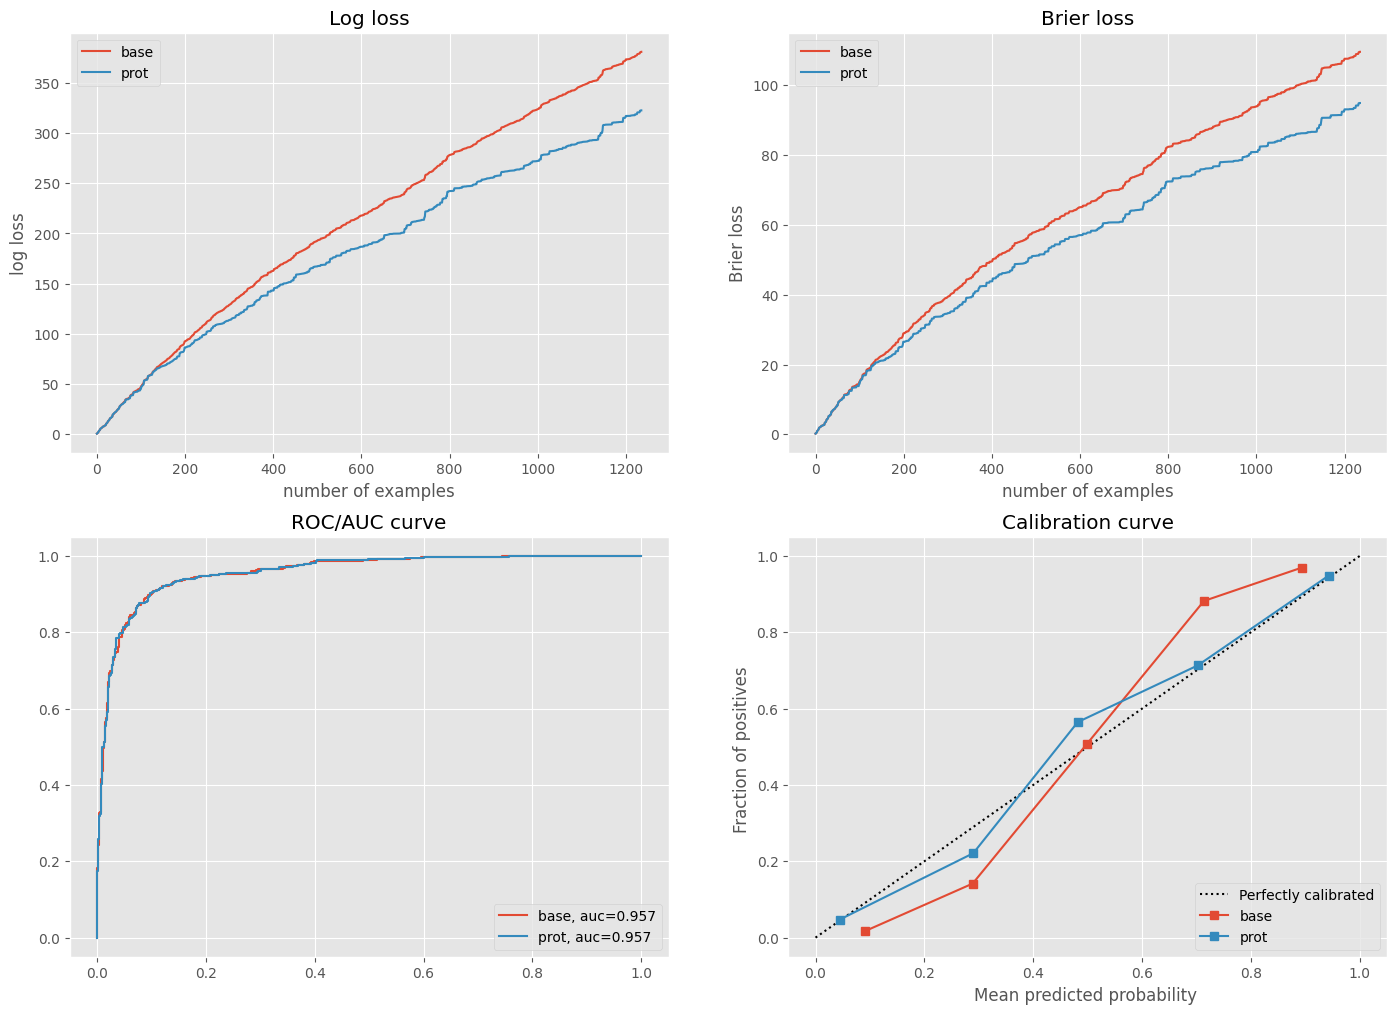

In [7]:
plt.style.use('ggplot')
thr=10

fig, ax = plt.subplots(2, 2, figsize=(17,12))

ax[0,0].plot(np.cumsum(logloss['base'][thr:]), label='base')
ax[0,0].plot(np.cumsum(logloss['prot'][thr:]), label='prot')
ax[0,0].set_ylabel('log loss')
ax[0,0].set_xlabel('number of examples')
ax[0,0].set_title('Log loss')
ax[0,0].legend()

ax[0,1].plot(np.cumsum(brierloss['base'][thr:]), label='base')
ax[0,1].plot(np.cumsum(brierloss['prot'][thr:]), label='prot')
ax[0,1].set_ylabel('Brier loss')
ax[0,1].set_xlabel('number of examples')
ax[0,1].set_title('Brier loss')
ax[0,1].legend()

fpr_pred, tpr_pred, thresh_pred = roc_curve(y_test[thr:], [p[1] for p in p_preds][thr:], pos_label=1)
auc_pred = roc_auc_score(y_test[thr:], [p[1] for p in p_preds][thr:])
ax[1,0].plot(fpr_pred,tpr_pred,label="base, auc="+str(np.around(auc_pred,decimals=3)))

fpr_prime, tpr_prime, thresh_prime = roc_curve(y_test[thr:], [p[1] for p in p_primes][thr:], pos_label=1)
auc_prime = roc_auc_score(y_test[thr:], [p[1] for p in p_primes][thr:])
ax[1,0].plot(fpr_prime,tpr_prime,label="prot, auc="+str(np.around(auc_prime,decimals=3)))
ax[1,0].legend()
ax[1,0].set_title('ROC/AUC curve')


prob_true, prob_pred = calibration_curve(y_test[thr:], [p[1] for p in p_preds][thr:], n_bins=5)
cal_display_pred = CalibrationDisplay(prob_true, prob_pred, y_test[thr:])
cal_display_pred.plot(ax = ax[1,1], name='base')
prob_true, prob_pred = calibration_curve(y_test[thr:], [p[1] for p in p_primes][thr:], n_bins=5)
cal_display_pred = CalibrationDisplay(prob_true, prob_pred, y_test[thr:])
cal_display_pred.plot(ax = ax[1,1], name='prot')
ax[1,1].set_title('Calibration curve')

plt.show()


In [8]:
df = pd.DataFrame(scratch, columns = [ 'metric', 'base', 'protected'])
df.index = df['metric']
df.drop(['metric'], axis=1, inplace=True)
display(df.round(3))

,base,protected
metric,,
log_loss,0.340,0.294
brier_loss,0.091,0.079
accuracy,0.897,0.897
ROC,0.894,0.894
cal_error,0.210,0.130


In this example the protected classification algorithm experiences a lower log and Brier loss, while delivering similar accuracy and ROC score, with better overall calibration